In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Analyze S&P Data

In [223]:
# extract from shiller's
snp = pd.read_excel("data/shiller_parsed.xlsx")
snp.tail()
# drop 2013 - 2016 due to lack of real Price and real Dividend Data
snp.drop(list(range(142, 146)), axis=0, inplace = True)


In [224]:
snp

,Year,P,D,E,R,RLONG,CPI,RealR,C,Unnamed: 9,...,P*,P*r,P*C,RealD,Return,ln(1+ret),RealE,P/E,E10,P/E10
0,1871,4.44,0.26,0.40,6.35,5.32,12.46406,1.047504,NaN,1871.0,...,112.0186,63.65037,NaN,4.731385,0.135809,0.127345,7.279054,NaN,NaN,NaN
1,1872,4.86,0.30,0.43,7.81,5.36,12.65439,1.054320,NaN,1872.0,...,114.2940,63.96204,NaN,5.338874,0.088615,0.084907,7.652386,12.150000,NaN,NaN
2,1873,5.11,0.33,0.46,8.35,5.58,12.93981,1.133511,NaN,1873.0,...,116.0708,64.04048,NaN,6.143830,0.021590,0.021360,8.564127,11.883720,NaN,NaN
3,1874,4.66,0.33,0.46,6.86,5.47,12.36890,1.148076,NaN,1874.0,...,117.1061,67.83171,NaN,6.600773,0.122790,0.115817,9.201078,10.130430,NaN,NaN
4,1875,4.54,0.30,0.36,4.96,5.07,11.51265,1.114055,NaN,1875.0,...,117.7222,72.63001,NaN,6.369199,0.112843,0.106918,7.643039,9.869565,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,2008,1378.76,28.39,14.88,3.42,3.74,211.18000,1.034381,30509.08,2008.0,...,809.8961,804.69450,928.8626,30.963130,-0.351500,-0.433090,16.228650,20.833480,59.21800,23.90981
138,2009,865.58,22.41,50.97,1.02,2.52,211.14300,0.984305,29933.85,2009.0,...,829.8037,829.80370,829.8037,23.815800,0.290082,0.254706,54.167400,58.170700,58.06330,15.94164
139,2010,1123.58,22.73,77.35,0.46,3.73,216.68700,0.988420,NaN,2010.0,...,NaN,NaN,NaN,23.768020,0.143124,0.133764,80.882370,22.043950,59.57587,20.56485
140,2011,1282.62,26.43,86.95,0.37,3.39,220.22300,0.975125,NaN,2011.0,...,NaN,NaN,NaN,26.851520,0.005204,0.005191,88.336730,16.582030,65.19915,22.51237


Text(0, 0.5, 'Price')

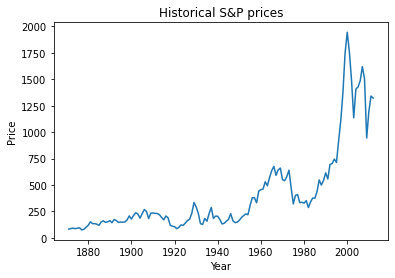

In [225]:
# Historical S&P prices
_=plt.plot(snp['Year'], snp['RealP'])
_=plt.title("Historical S&P prices")
plt.xlabel('Year')
plt.ylabel('Price')

We want to detrend the data according to a long run avg lambda = (1 + g)

Growth Factor (g): 0.017275532726949372


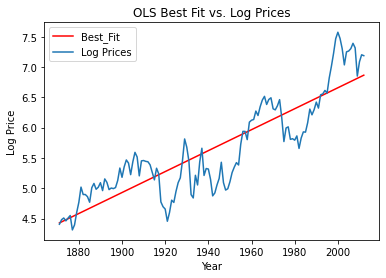

In [226]:
# OLS to get gt + log(P_0) = log(P_t)
X = np.vstack([np.ones_like(snp['Year']), snp['Year']]).transpose()
y = np.log(snp['RealP']).to_numpy()
W = np.linalg.inv(X.transpose() @ X) @ (X.transpose() @ y)
g = W[1]
print("Growth Factor (g):", g)

# Plot log prices vs linear regression
best_fit_y = W @ np.vstack([np.ones_like(snp['Year']), snp['Year']])
plt.plot(snp['Year'], best_fit_y, label ='Best_Fit', c = 'red')
plt.plot(snp['Year'], np.log(snp['RealP']), label = 'Log Prices')
plt.title("OLS Best Fit vs. Log Prices")
plt.xlabel("Year")
plt.ylabel("Log Price")
plt.legend()

In [227]:
np.exp(g)

1.0174256177631147

In [228]:
# Detrend each price according to (1 + g)^t
snp['detrended_P'] = snp['RealP']/(1+g)**(snp.index)
snp['detrended_P']

0       82.031310
1       86.938590
2       87.876372
3       82.412936
4       84.797362
          ...    
137    143.881214
138     88.809636
139    110.423617
140    121.923587
141    118.077241
Name: detrended_P, Length: 142, dtype: float64

Text(0, 0.5, 'Detrended Price')

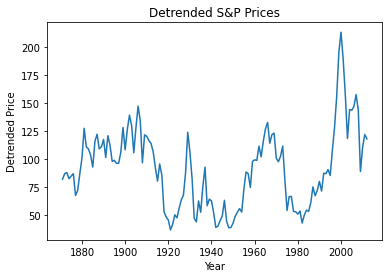

In [229]:
# Plot detrended prices
plt.plot(snp['Year'], snp['detrended_P'])
plt.title("Detrended S&P Prices")
plt.xlabel("Year")
plt.ylabel("Detrended Price")

We also want to compute Dividend growth and detrend it in the same manner.

# Find P* via Dividend Growth Model and detrend

Now that all our dividends and prices are detrended, we would like to determine P*

P* is dependent on the price of future dividends and g. Thus, we must make an assumption regarding future dividends 2013 and after. 

In [230]:
# Compute the geometric return
geo_r = np.exp(np.log(1 + (snp['RealP'].shift(-1) - snp['RealP'] + snp['RealD'])/snp['RealP']).mean()) -1

snp['returns'] = (snp['RealP'].shift(-1) - snp['RealP'] + snp['RealD'])/snp['RealP']

In [231]:
geo_r

0.06476967709390702

In [232]:
# Compute P*_2012 (Immediately after the 2012 dividend is paid out), by approximating future dividends via the avg growth
P_star_2012 = snp['RealP'].iloc[-1] # approximate using the true 2012 value, like saying we know for sure the future value is this.
print("P*_2012:", P_star_2012)

# recursively compute new dividends
pstar = [P_star_2012]
for idx, D in enumerate(snp['RealD'].to_numpy()[-2::-1]):
    # append discounted value of future year + current D
    pstar.append(pstar[-1] / (1 + geo_r) + D)

snp['computed_P*'] = np.array(pstar[::-1])
print(snp['computed_P*'])

P*_2012: 1321.322
0       113.143383
1       115.433808
2       117.225748
3       118.276658
4       118.909096
          ...     
137    1124.521100
138    1164.387367
139    1214.446019
140    1267.797828
141    1321.322000
Name: computed_P*, Length: 142, dtype: float64


In [233]:
np.array(pstar[::-1])

array([ 113.14338327,  115.43380839,  117.22574774,  118.27665768,
        118.90909567,  119.82906944,  120.86761253,  123.64831613,
        126.32515413,  129.5985436 ,  131.22458795,  132.0168909 ,
        132.7137432 ,  132.54224638,  131.94437948,  133.12737063,
        135.00056684,  136.42336769,  138.20325248,  140.06774276,
        142.22584592,  144.07476327,  145.95472844,  146.46007256,
        148.10304958,  150.70078201,  153.64001741,  156.96452797,
        159.87177357,  163.7063697 ,  164.76494042,  165.50109846,
        166.87520826,  167.31622607,  169.17696411,  170.57910717,
        170.54332564,  169.12890528,  169.11713918,  169.16791156,
        167.63807431,  165.87916292,  164.61354425,  163.50614262,
        163.90014825,  164.3780314 ,  163.28890527,  161.78046084,
        163.78855105,  167.6637443 ,  171.94171655,  176.40437523,
        180.38660496,  184.55842764,  188.716996  ,  192.72130234,
        195.53610438,  197.28760051,  197.87778757,  196.78553

In [234]:
# Detrend according to same as P
snp['detrended_P*'] = snp['computed_P*']/(1 + g)**(snp.index)

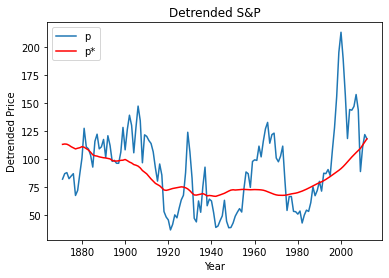

In [235]:
# Plot P and P* together
# plot detrended
plt.plot(snp['Year'], snp['detrended_P'], label = 'p')
plt.plot(snp['Year'], snp['detrended_P*'], c = 'red', label = 'p*')

plt.xlabel("Year")
plt.ylabel("Detrended Price")
plt.title("Detrended S&P")
plt.legend()

In [236]:
print("STD P:", snp['detrended_P'].std())
print("STD P*", snp['detrended_P*'].std())

STD P: 34.8462477361639
STD P* 15.59811577790943


This verifies that the std of P > STD P, implying that markets are not following the efficient market hypothesis

Suppose the exact returns are known when computing P

In [237]:
snp

,Year,P,D,E,R,RLONG,CPI,RealR,C,Unnamed: 9,...,Return,ln(1+ret),RealE,P/E,E10,P/E10,detrended_P,returns,computed_P*,detrended_P*
0,1871,4.44,0.26,0.40,6.35,5.32,12.46406,1.047504,NaN,1871.0,...,0.135809,0.127345,7.279054,NaN,NaN,NaN,82.031310,0.135809,113.143383,113.143383
1,1872,4.86,0.30,0.43,7.81,5.36,12.65439,1.054320,NaN,1872.0,...,0.088615,0.084907,7.652386,12.150000,NaN,NaN,86.938590,0.088615,115.433808,113.473493
2,1873,5.11,0.33,0.46,8.35,5.58,12.93981,1.133511,NaN,1873.0,...,0.021590,0.021360,8.564127,11.883720,NaN,NaN,87.876372,0.021590,117.225748,113.278063
3,1874,4.66,0.33,0.46,6.86,5.47,12.36890,1.148076,NaN,1874.0,...,0.122790,0.115817,9.201078,10.130430,NaN,NaN,82.412936,0.122790,118.276658,112.352631
4,1875,4.54,0.30,0.36,4.96,5.07,11.51265,1.114055,NaN,1875.0,...,0.112843,0.106918,7.643039,9.869565,NaN,NaN,84.797362,0.112843,118.909096,111.035200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,2008,1378.76,28.39,14.88,3.42,3.74,211.18000,1.034381,30509.08,2008.0,...,-0.351500,-0.433090,16.228650,20.833480,59.21800,23.90981,143.881214,-0.351499,1124.521100,107.616667
138,2009,865.58,22.41,50.97,1.02,2.52,211.14300,0.984305,29933.85,2009.0,...,0.290082,0.254706,54.167400,58.170700,58.06330,15.94164,88.809636,0.290082,1164.387367,109.539515
139,2010,1123.58,22.73,77.35,0.46,3.73,216.68700,0.988420,NaN,2010.0,...,0.143124,0.133764,80.882370,22.043950,59.57587,20.56485,110.423617,0.143124,1214.446019,112.308582
140,2011,1282.62,26.43,86.95,0.37,3.39,220.22300,0.975125,NaN,2011.0,...,0.005204,0.005191,88.336730,16.582030,65.19915,22.51237,121.923587,0.005204,1267.797828,115.251380


In [238]:
# Compute P*_2012 (Immediately after the 2012 dividend is paid out), by approximating future dividends via the avg growth
P_star_2012 = snp['RealP'].iloc[-1] # approximate using the true 2012 value, like saying we know for sure the future value is this.
print("P*_2012:", P_star_2012)

# recursively compute new dividends
pstar = [P_star_2012]
for idx, D in enumerate(snp['RealD'].to_numpy()[-2::-1]):
    # append discounted value of future year + current D
    pstar.append(pstar[-1] / (1 + snp['returns'].iloc[-(idx + 2)]) + D)

snp['computed_P*_exact'] = np.array(pstar[::-1])
print(snp['computed_P*_exact'])

P*_2012: 1321.322
0        87.809404
1        94.360746
2        96.910584
3        92.726380
4        96.700997
          ...     
137    1498.638444
138     951.788194
139    1197.160463
140    1341.333011
141    1321.322000
Name: computed_P*_exact, Length: 142, dtype: float64


In [239]:
snp['detrended_P*_exact'] = snp['computed_P*_exact']/(1 + g)**(snp.index)

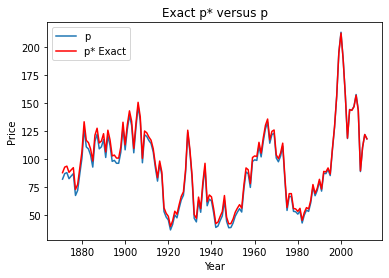

In [240]:
plt.plot(snp['Year'], snp['detrended_P'], label = 'p')
plt.plot(snp['Year'], snp['detrended_P*_exact'], label = 'p* Exact', c = 'red')

plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Exact p* versus p")
plt.legend()


In [241]:
print("STD P:", snp['detrended_P'].std())
print("STD P* Exact", snp['detrended_P*_exact'].std())

STD P: 34.8462477361639
STD P* Exact 34.40469709591939


# Backward Analysis

In [242]:
# get data

In [243]:
snp = pd.read_excel("data/shiller_parsed.xlsx")
snp.tail()

,Year,P,D,E,R,RLONG,CPI,RealR,C,Unnamed: 9,...,P*,P*r,P*C,RealD,Return,ln(1+ret),RealE,P/E,E10,P/E10
141,2012,1300.58,31.25,86.51,NaN,1.97,226.665,0.984302,NaN,2012.0,...,NaN,NaN,NaN,31.25,0.144043,0.134569,NaN,14.95779,68.55832,20.26595
142,2013,1480.40,34.99,100.20,NaN,1.91,230.280,NaN,NaN,2013.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.55262,21.59329
143,2014,1822.36,39.44,102.31,NaN,2.86,233.916,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,2015,2028.18,43.39,NaN,NaN,1.88,233.707,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,2016,1918.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [244]:
# P_t = E[P_t*]
# E[P_t*] = D_{t}(1 + E[G]) E[1/(R-G)]

In [245]:
# at time t, only D_t and P_t are known
# D_t is the dividend paid at time t. P_t is the price after D_t is paid

# we shift RealD to reflect this
snp['P_t'] = snp['RealP']
snp['D_t'] = snp['RealD'].shift(1)

snp[['P_t', 'D_t']]

,P_t,D_t
0,82.03131,NaN
1,88.44050,4.731385
2,90.93882,5.338874
3,86.75833,6.143830
4,90.81064,6.600773
...,...,...
141,1321.32200,26.851520
142,1480.40000,31.250000
143,1794.03300,NaN
144,1998.43900,NaN


In [246]:
# Assume G and R are normally distributed
# Based on historical data, compute a normal distribution
# G - Normal(gmean, gvar)
# R - Normal(rmean, rvar)

# to compute E[1/(R-G)], R and G are not independent, so be construct a bivariate normal distribution

# G, R - Normal([gmean, rmean], [[rvar, rgcov],[rgcov, gvar]])

In [247]:
# Compute historical g and r (only known at )
# logr ~ ln((P_{t+1} + D_t)/P_t))
snp['logr'] = np.log((snp['P_t'] + snp['D_t'])/snp['P_t'].shift(1))

# logg ~ ln((D_{t+1}/D_t))
snp['logg'] = np.log(snp['D_t']/snp['D_t'].shift(1))
snp[['P_t', 'logr', 'D_t', 'logg']]

,P_t,logr,D_t,logg
0,82.03131,NaN,NaN,NaN
1,88.44050,0.127345,4.731385,NaN
2,90.93882,0.084907,5.338874,0.120797
3,86.75833,0.021360,6.143830,0.140434
4,90.81064,0.115817,6.600773,0.071738
...,...,...,...,...
141,1321.32200,0.005190,26.851520,0.121981
142,1480.40000,0.134569,31.250000,0.151697
143,1794.03300,NaN,NaN,NaN
144,1998.43900,NaN,NaN,NaN


In [248]:
snp

,Year,P,D,E,R,RLONG,CPI,RealR,C,Unnamed: 9,...,Return,ln(1+ret),RealE,P/E,E10,P/E10,P_t,D_t,logr,logg
0,1871,4.44,0.26,0.40,6.35,5.32,12.46406,1.047504,NaN,1871.0,...,0.135809,0.127345,7.279054,NaN,NaN,NaN,82.03131,NaN,NaN,NaN
1,1872,4.86,0.30,0.43,7.81,5.36,12.65439,1.054320,NaN,1872.0,...,0.088615,0.084907,7.652386,12.150000,NaN,NaN,88.44050,4.731385,0.127345,NaN
2,1873,5.11,0.33,0.46,8.35,5.58,12.93981,1.133511,NaN,1873.0,...,0.021590,0.021360,8.564127,11.883720,NaN,NaN,90.93882,5.338874,0.084907,0.120797
3,1874,4.66,0.33,0.46,6.86,5.47,12.36890,1.148076,NaN,1874.0,...,0.122790,0.115817,9.201078,10.130430,NaN,NaN,86.75833,6.143830,0.021360,0.140434
4,1875,4.54,0.30,0.36,4.96,5.07,11.51265,1.114055,NaN,1875.0,...,0.112843,0.106918,7.643039,9.869565,NaN,NaN,90.81064,6.600773,0.115817,0.071738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2012,1300.58,31.25,86.51,NaN,1.97,226.66500,0.984302,NaN,2012.0,...,0.144043,0.134569,NaN,14.957790,68.55832,20.26595,1321.32200,26.851520,0.005190,0.121981
142,2013,1480.40,34.99,100.20,NaN,1.91,230.28000,NaN,NaN,2013.0,...,NaN,NaN,NaN,NaN,69.55262,21.59329,1480.40000,31.250000,0.134569,0.151697
143,2014,1822.36,39.44,102.31,NaN,2.86,233.91600,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1794.03300,NaN,NaN,NaN
144,2015,2028.18,43.39,NaN,NaN,1.88,233.70700,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1998.43900,NaN,NaN,NaN


In [249]:
# std of r
sigmar = (np.exp(snp['logr']) - 1).std()
ur = (np.exp(snp['logr'].mean()) - 1)
print("simga r:", sigmar)
print("Mean r:", ur)

simga r: 0.1771966087165512
Mean r: 0.06530827560891406


# Case 1

In [250]:
snp

,Year,P,D,E,R,RLONG,CPI,RealR,C,Unnamed: 9,...,Return,ln(1+ret),RealE,P/E,E10,P/E10,P_t,D_t,logr,logg
0,1871,4.44,0.26,0.40,6.35,5.32,12.46406,1.047504,NaN,1871.0,...,0.135809,0.127345,7.279054,NaN,NaN,NaN,82.03131,NaN,NaN,NaN
1,1872,4.86,0.30,0.43,7.81,5.36,12.65439,1.054320,NaN,1872.0,...,0.088615,0.084907,7.652386,12.150000,NaN,NaN,88.44050,4.731385,0.127345,NaN
2,1873,5.11,0.33,0.46,8.35,5.58,12.93981,1.133511,NaN,1873.0,...,0.021590,0.021360,8.564127,11.883720,NaN,NaN,90.93882,5.338874,0.084907,0.120797
3,1874,4.66,0.33,0.46,6.86,5.47,12.36890,1.148076,NaN,1874.0,...,0.122790,0.115817,9.201078,10.130430,NaN,NaN,86.75833,6.143830,0.021360,0.140434
4,1875,4.54,0.30,0.36,4.96,5.07,11.51265,1.114055,NaN,1875.0,...,0.112843,0.106918,7.643039,9.869565,NaN,NaN,90.81064,6.600773,0.115817,0.071738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2012,1300.58,31.25,86.51,NaN,1.97,226.66500,0.984302,NaN,2012.0,...,0.144043,0.134569,NaN,14.957790,68.55832,20.26595,1321.32200,26.851520,0.005190,0.121981
142,2013,1480.40,34.99,100.20,NaN,1.91,230.28000,NaN,NaN,2013.0,...,NaN,NaN,NaN,NaN,69.55262,21.59329,1480.40000,31.250000,0.134569,0.151697
143,2014,1822.36,39.44,102.31,NaN,2.86,233.91600,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1794.03300,NaN,NaN,NaN
144,2015,2028.18,43.39,NaN,NaN,1.88,233.70700,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1998.43900,NaN,NaN,NaN


In [251]:
snp['RealD'].iloc[0:142]

0       4.731385
1       5.338874
2       6.143830
3       6.600773
4       6.369199
         ...    
137    30.963130
138    23.815800
139    23.768020
140    26.851520
141    31.250000
Name: RealD, Length: 142, dtype: float64

In [252]:
g

0.017275532726949372

In [253]:
n = 1000

sigmar = (np.exp(snp['logr']) - 1).std()
ur = (np.exp(snp['logr'].mean()) - 1)
print("simga r:", sigmar)
print("Mean r:", ur)

vars = []
arrs = []
for i in range(n):
    # Compute P*_2012 (Immediately after the 2012 dividend is paid out), by approximating future dividends via the avg growth
    P_star_2012 = snp['RealP'].iloc[141] # approximate using the true 2012 value, like saying we know for sure the future value is this.
    #print("P*_2012:", P_star_2012)

    # recursively compute new dividends
    pstar = [P_star_2012]
    divs = snp['RealD'].iloc[0:142].to_numpy()[-2::-1]
    rs = np.random.normal( ur,sigmar, size=len(divs) )
    for idx, D in enumerate(divs):
        # append discounted value of future year + current D
        pstar.append(pstar[-1] / (1 + rs[idx]) + D)

    pstar = np.array(pstar[::-1])
    # save every 10
    detrended_pstar = pstar/(1 + g)**(np.arange(len(pstar)))
    vars.append(detrended_pstar.var())
    if i % 100 == 0:
        print(f"Ran {i}/{n}")
        arrs.append(detrended_pstar)
    

simga r: 0.1771966087165512
Mean r: 0.06530827560891406
Ran 0/1000
Ran 100/1000
Ran 200/1000
Ran 300/1000
Ran 400/1000
Ran 500/1000
Ran 600/1000
Ran 700/1000
Ran 800/1000
Ran 900/1000


In [254]:
from statsmodels.stats.weightstats import ztest

In [255]:
vars

[5727.049614214376,
 871.2627937034557,
 823.2940006861313,
 19009.52818133834,
 31340.200436363415,
 10332.445134208116,
 5852.406749509724,
 1190.7651715396012,
 1871.9590825040639,
 3583.5650312908547,
 8341.268697558507,
 16991.712808865006,
 3267.8104171991663,
 13646.77209711966,
 6274.500974534802,
 945.6177807221079,
 13986.361312168781,
 4951.202698636516,
 3075.633643866178,
 6857.407202270564,
 2807.6585639746913,
 1401.2155400761442,
 2133.5912212135854,
 7425.765995363805,
 1209.5393922571511,
 5607.535284009346,
 992.9683377122749,
 74135.91605886536,
 50701.21724026707,
 14092.08406477595,
 683.7978821783482,
 52299.503564787075,
 10747.315914377374,
 1012.482271751047,
 13687.00229386138,
 5239.560767121301,
 29286.958633856735,
 2047.279076666695,
 171239.47952343538,
 4019.8840423696224,
 2291.5217915616404,
 46987.53697263356,
 15609.728301038569,
 425613.94611612085,
 1237.0850025014406,
 12018.340694241595,
 9235.4498875578,
 1013.4680143737274,
 1646.8565238426434

In [256]:
np.array(vars).mean()**(1/2)

148.89074260990955

In [257]:
ztest(np.array(vars)**(1/2), value=34.84625)

(18.76541361596913, 1.448656315446034e-78)

In [258]:
snp['r'] = np.exp(snp['logr']) -1
snp['g'] = np.exp(snp['logg']) -1
snp


,Year,P,D,E,R,RLONG,CPI,RealR,C,Unnamed: 9,...,RealE,P/E,E10,P/E10,P_t,D_t,logr,logg,r,g
0,1871,4.44,0.26,0.40,6.35,5.32,12.46406,1.047504,NaN,1871.0,...,7.279054,NaN,NaN,NaN,82.03131,NaN,NaN,NaN,NaN,NaN
1,1872,4.86,0.30,0.43,7.81,5.36,12.65439,1.054320,NaN,1872.0,...,7.652386,12.150000,NaN,NaN,88.44050,4.731385,0.127345,NaN,0.135809,NaN
2,1873,5.11,0.33,0.46,8.35,5.58,12.93981,1.133511,NaN,1873.0,...,8.564127,11.883720,NaN,NaN,90.93882,5.338874,0.084907,0.120797,0.088615,0.128396
3,1874,4.66,0.33,0.46,6.86,5.47,12.36890,1.148076,NaN,1874.0,...,9.201078,10.130430,NaN,NaN,86.75833,6.143830,0.021360,0.140434,0.021590,0.150773
4,1875,4.54,0.30,0.36,4.96,5.07,11.51265,1.114055,NaN,1875.0,...,7.643039,9.869565,NaN,NaN,90.81064,6.600773,0.115817,0.071738,0.122790,0.074374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,2012,1300.58,31.25,86.51,NaN,1.97,226.66500,0.984302,NaN,2012.0,...,NaN,14.957790,68.55832,20.26595,1321.32200,26.851520,0.005190,0.121981,0.005204,0.129733
142,2013,1480.40,34.99,100.20,NaN,1.91,230.28000,NaN,NaN,2013.0,...,NaN,NaN,69.55262,21.59329,1480.40000,31.250000,0.134569,0.151697,0.144044,0.163807
143,2014,1822.36,39.44,102.31,NaN,2.86,233.91600,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1794.03300,NaN,NaN,NaN,NaN,NaN
144,2015,2028.18,43.39,NaN,NaN,1.88,233.70700,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1998.43900,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Detrended P vs. Various Detrended P*')

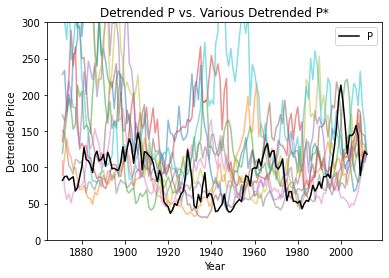

In [259]:
#plot
for a in arrs:
     plt.plot(snp['Year'].iloc[0:142], a, alpha = .5)
plt.plot(snp['Year'].iloc[0:142], (snp['RealP']/(1+g)**(snp.index)).iloc[0:142], label = 'P', c = 'black',)
plt.ylim(0, 300)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Detrended Price")
plt.title("Detrended P vs. Various Detrended P*")

# Case 2

In [271]:
n = 1000

sigmag = (np.exp(snp['logg']) - 1).std()
ug = (np.exp(snp['logg'].mean()) - 1)

rho = (np.exp((snp['logg'])) - 1).shift(-1).corr((np.exp((snp['logr'])) - 1))
sigmar = (np.exp(snp['logr']) - 1).std()
ur = (np.exp(snp['logr'].mean()) - 1)
print("simga r:", sigmar)
print("Mean r:", ur)
print("sigma g:", sigmag)
print("Mean g:", ug)
print("Corr :", rho)

vars = []
arrs = []
for i in range(n):
    # Compute P*_2012 (Immediately after the 2012 dividend is paid out), by approximating future dividends via the avg growth
    P_star_2012 = snp['RealP'].iloc[141] # approximate using the true 2012 value, like saying we know for sure the future value is this.
    #print("P*_2012:", P_star_2012)

    # recursively compute new dividends
    pstar = [P_star_2012]
    divs = snp['RealD'].iloc[1:142].to_numpy()[-2::-1]
    gs = snp['g'].iloc[1:142].to_numpy()[-1::-1]
    for idx, D in enumerate(divs):
        newg = gs[idx]
        r = np.random.normal(ur + rho * (sigmar / sigmag) * (newg - ug), ((sigmar**2)*(1 - rho**2))**(1/2), size=1 ).item()
        # append discounted value of future year + current D
        pstar.append(pstar[-1] / (1 + r) + D)

    pstar = np.array(pstar[::-1])
    # save every 10
    detrended_pstar = pstar/(1 + g)**(np.arange(len(pstar)))
    vars.append(detrended_pstar.var())
    if i % 100 == 0:
        print(f"Ran {i}/{n}")
        arrs.append(detrended_pstar)
    

simga r: 0.1771966087165512
Mean r: 0.06530827560891406
sigma g: 0.11850201603673988
Mean g: 0.013478691928480613
Corr : 0.4144394660451609
Ran 0/1000
Ran 100/1000
Ran 200/1000
Ran 300/1000
Ran 400/1000
Ran 500/1000
Ran 600/1000
Ran 700/1000
Ran 800/1000
Ran 900/1000


In [272]:
vars[0:10]

[7532.097423083149,
 6118.526049507267,
 2600.304938643545,
 7018.077024570427,
 1366.5336495027032,
 2495.477597282232,
 2465.9075858422243,
 22673.736637612255,
 779.3667036988853,
 871.6912029860506]

In [273]:
np.array(vars).mean()**(1/2)

109.94626634005051

In [278]:
ztest(np.array(vars)**(1/2), value=34.84625)

(19.332601907728133, 2.8564291390019097e-83)

Text(0.5, 1.0, 'Detrended P vs. Various Detrended P*')

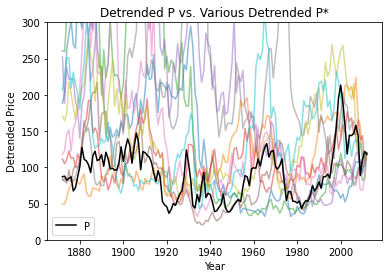

In [275]:
#plot
for a in arrs:
     plt.plot(snp['Year'].iloc[1:142], a, alpha = .5)
plt.plot(snp['Year'].iloc[1:142], (snp['RealP']/(1+g)**(snp.index)).iloc[1:142], label = 'P', c = 'black',)
plt.ylim(0, 300)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Detrended Price")
plt.title("Detrended P vs. Various Detrended P*")

# ENd of Back Analysis

In [174]:
# Compute historical means of r and g
snp['rmean'] = np.exp(snp['logr'].cumsum()/snp.index) - 1
snp['gmean'] = np.exp(snp['logg'].cumsum()/(snp.index - 1)) - 1

# If you assume you knew what dividends were going to be
snp['gmean_future'] = snp['gmean'].shift(-1)
snp[['P_t', 'logr', 'D_t', 'logg', 'rmean', 'gmean', 'gmean_future']]

,P_t,logr,D_t,logg,rmean,gmean,gmean_future
0,82.03131,NaN,NaN,NaN,NaN,NaN,NaN
1,88.44050,0.127345,4.731385,NaN,0.135809,NaN,0.128396
2,90.93882,0.084907,5.338874,0.120797,0.111962,0.128396,0.139529
3,86.75833,0.021360,6.143830,0.140434,0.080983,0.139529,0.117383
4,90.81064,0.115817,6.600773,0.071738,0.091286,0.117383,0.077145
...,...,...,...,...,...,...,...
141,1321.32200,0.005190,26.851520,0.121981,0.064770,0.012478,0.013479
142,1480.40000,0.134569,31.250000,0.151697,0.065308,0.013479,NaN
143,1794.03300,NaN,NaN,NaN,NaN,NaN,NaN
144,1998.43900,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Detrended P vs. Various Detrended P*')

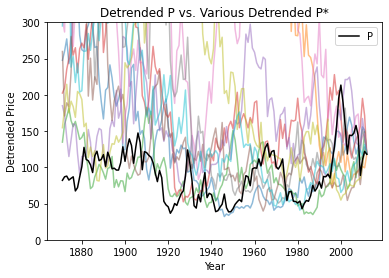

In [84]:
# Compute historical means of r and g
snp['rmean'] = np.exp(snp['logr'].cumsum()/snp.index) - 1
snp['gmean'] = np.exp(snp['logg'].cumsum()/(snp.index - 1)) - 1

# If you assume you knew what dividends were going to be
snp['gmean_future'] = snp['gmean'].shift(-1)
snp[['P_t', 'logr', 'D_t', 'logg', 'rmean', 'gmean', 'gmean_future']]

,P_t,logr,D_t,logg,rmean,gmean,gmean_future
0,82.03131,NaN,NaN,NaN,NaN,NaN,NaN
1,88.44050,0.127345,4.731385,NaN,0.135809,NaN,0.128396
2,90.93882,0.084907,5.338874,0.120797,0.111962,0.128396,0.139529
3,86.75833,0.021360,6.143830,0.140434,0.080983,0.139529,0.117383
4,90.81064,0.115817,6.600773,0.071738,0.091286,0.117383,0.077145
...,...,...,...,...,...,...,...
141,1321.32200,0.005190,26.851520,0.121981,0.064770,0.012478,0.013479
142,1480.40000,0.134569,31.250000,0.151697,0.065308,0.013479,NaN
143,1794.03300,NaN,NaN,NaN,NaN,NaN,NaN
144,1998.43900,NaN,NaN,NaN,NaN,NaN,NaN


Do some plotting

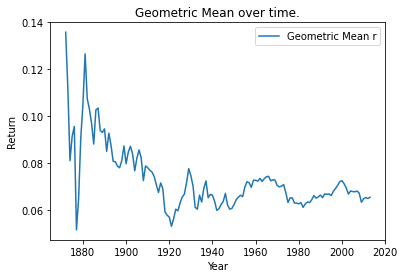

In [85]:
plt.plot(snp['Year'], snp['rmean'], label = 'Geometric Mean r')
plt.xlabel('Year')
plt.ylabel("Return")
plt.title("Geometric Mean over time.")
plt.legend()

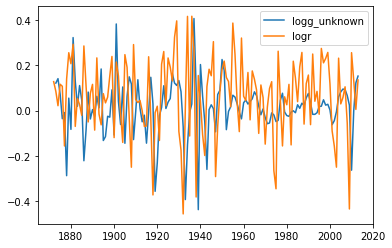

In [143]:
plt.plot(snp['Year'], snp['logg'], label='logg_unknown')
plt.plot(snp['Year'], snp['logr'], label='logr')

plt.legend()


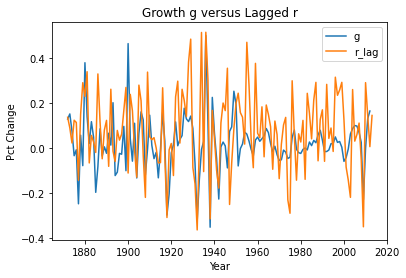

In [98]:
plt.plot(snp['Year'], np.exp(snp['logg'].shift(-1)) -1 , label='g')
plt.plot(snp['Year'], np.exp(snp['logr']) -1, label='r_lag')
plt.xlabel('Year')
plt.ylabel("Pct Change")
plt.title("Growth g versus Lagged r")
plt.legend()


Compute variance and covariances of the log returns

In [131]:
# Historical covariance for data at time t
snp['var_r'] = np.nan
snp['var_g'] = np.nan
snp['cov_r_g'] = np.nan

def regret(s):
    return np.exp(s)-1
    
for t in range(len(snp)):
    
    # retrieve data up to t
    data = snp.iloc[:t+1]
    
    snp.at[i, 'var_r'] = regret(data['logr']).var()
    snp.at[i,'var_g'] = regret(data['logg']).var()
    
    # Covariance assuming No data is known, and no pattern between Dnext and R is associated
    snp.at[i, 'cov_r_g'] = regret(data['logr']).cov(regret(data['logg']))
    
snp[['var_r', 'var_g', 'cov_r_g']]

/opt/anaconda3/envs/School/lib/python3.8/site-packages/pandas/core/nanops.py:1601: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(a, b, ddof=ddof)[0, 1]
/opt/anaconda3/envs/School/lib/python3.8/site-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,var_r,var_g,cov_r_g
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,0.001114,0.000250,-0.000528
4,0.003294,0.001543,0.001706
...,...,...,...
141,0.031781,0.013995,0.008870
142,0.031594,0.014043,0.008729
143,0.031399,0.014043,0.008729
144,0.031399,0.014043,0.008729


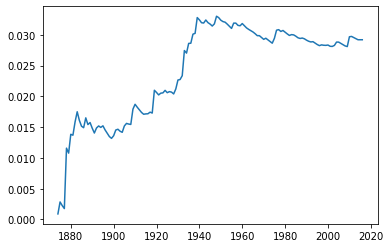

In [37]:
plt.plot(snp['Year'], snp['var_r'])

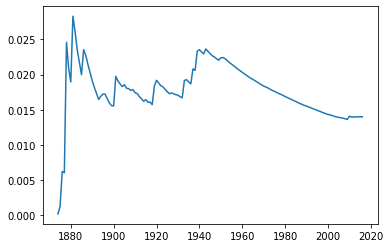

In [38]:
plt.plot(snp['Year'], snp['var_g'])

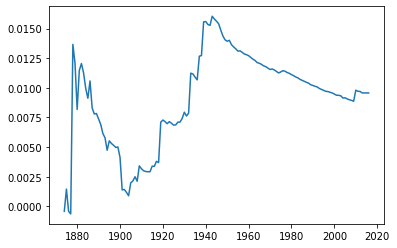

In [39]:
plt.plot(snp['Year'], snp['cov_r_g'])

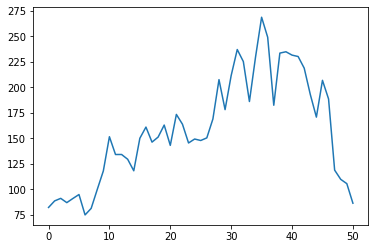

In [83]:
plt.plot(snp.index[:51], snp['RealP'][:51])

In [98]:
idx = 100

mean = [snp['rmean'].iloc[idx], snp['gmean'].iloc[idx]]
cov = [[snp['var_r'].iloc[idx], snp['cov_r_g'].iloc[idx]], [snp['cov_r_g'].iloc[idx], snp['var_g'].iloc[idx],]]

num_samples = 100000
samples = np.random.multivariate_normal(mean, cov, size=num_samples)


In [99]:

# Compute h(G, R) = 1/(R-G)
G = samples[:, 0]
R = samples[:, 1]
h = 1 / (R - G)
h_clean = h[np.isfinite(h)]  # Remove infinite values due to division by zero
h_clean = h[R>G]
print((R-G).mean())
h_clean = h[R - G > 0.001]

-0.05521935649750132


In [100]:
snp['RealP'][:idx].var()

20089.157235769326

In [101]:
snp['RealP'][idx]

540.9266

In [102]:
(1 + G[R>G].mean())

0.9490460708068079

In [103]:
h_clean.mean() * snp['RealD'].iloc[idx-1] * (1 + G[R>G].mean())

548.063441718421

In [104]:
variance = np.var(h_clean)
print(variance)

5771.666492871041
